In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from math import radians, sin, cos, sqrt, atan2

In [2]:
# Load dataset
df = pd.read_csv('Trip_Duration_Data.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
# Check the number of rows and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
# Show Statistical Summary
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:
# Check for missing values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
# Check for duplicate rows
df.duplicated().sum()

np.int64(0)

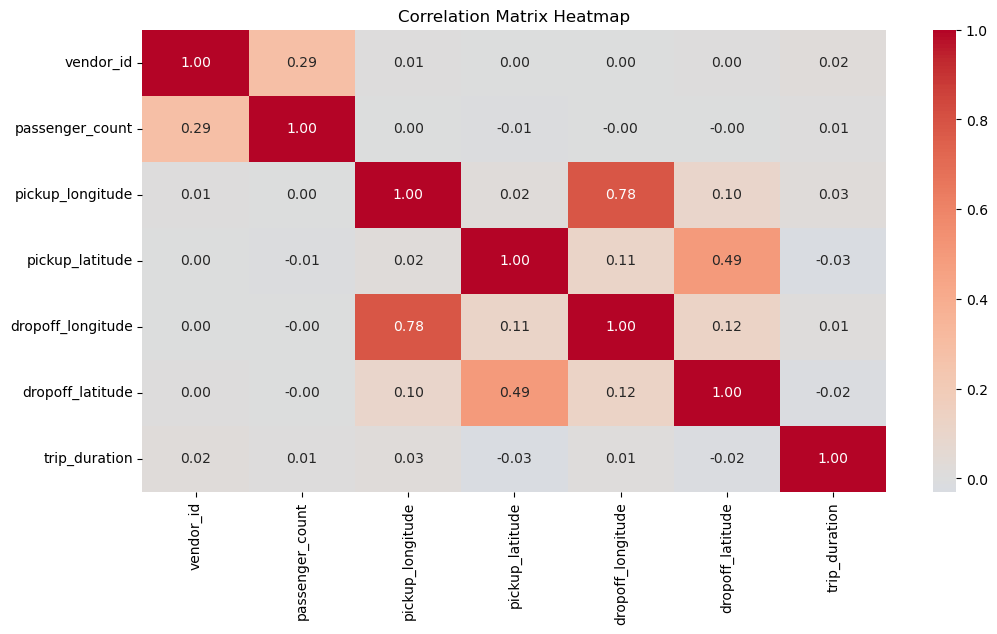

In [7]:
# Show correlation matrix
# Choose numerical columns for correlation heatmap
plt.figure(figsize=(12, 6))

numerical_cols = df.select_dtypes(include="number").columns.tolist()

# Calculate correlation matrix
corr = df[numerical_cols].corr()

# Plot heatmap
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [8]:
# Feature Engineering, create distance and time features
# 1. Log1p transformation of trip_duration
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# 2. Time features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

# 3. Distance features
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Haversine distance (great-circle distance)
df['haversine_distance'] = df.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], 
                         row['dropoff_latitude'], row['dropoff_longitude']),
    axis=1
)

# Manhattan distance
df['manhattan_distance'] = abs(df['pickup_latitude'] - df['dropoff_latitude']) + \
                           abs(df['pickup_longitude'] - df['dropoff_longitude'])

# Euclidean distance
df['euclidean_distance'] = np.sqrt((df['pickup_latitude'] - df['dropoff_latitude'])**2 + \
                                   (df['pickup_longitude'] - df['dropoff_longitude'])**2)

# Latitude and Longitude differences
df['lat_diff'] = abs(df['pickup_latitude'] - df['dropoff_latitude'])
df['lon_diff'] = abs(df['pickup_longitude'] - df['dropoff_longitude'])

# Speed Features for haversine_distance
df['avg_speed_kmh'] = df['haversine_distance'] / (df['trip_duration'] / 3600)
df['avg_speed_kmh'] = df['avg_speed_kmh'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['avg_speed_kmh'])

df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,hour,day_of_week,month,haversine_distance,manhattan_distance,euclidean_distance,lat_diff,lon_diff,avg_speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,6.122493,17,0,3,1.498521,0.019859,0.017680,0.002335,0.017525,11.856428
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.498282,0,6,6,1.805507,0.026478,0.020456,0.007412,0.019066,9.803659
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,7.661527,11,1,1,6.385098,0.080158,0.059934,0.053852,0.026306,10.822201
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,6.063785,19,2,4,1.485498,0.015480,0.013438,0.013252,0.002228,12.465721
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,6.077642,13,5,3,1.188588,0.010818,0.010690,0.010689,0.000130,9.836594


In [9]:
# Making a sample of the data
# We create two copies of the sample for different purposes:
# df_outlier: used for outlier analysis and visualization
# df_model: used for modeling after outlier handling
df_sample = df.sample(100_000, random_state=42)
df_outlier = df_sample.copy()
df_model = df_sample.copy()
df_outlier.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,hour,day_of_week,month,haversine_distance,manhattan_distance,euclidean_distance,lat_diff,lon_diff,avg_speed_kmh
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,...,6.947937,7,2,6,2.763050,0.029804,0.025087,0.024525,0.005280,9.564402
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,...,6.719013,12,6,4,1.959178,0.027721,0.019622,0.014492,0.013229,8.528467
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,...,6.421622,2,6,6,1.404772,0.019981,0.016258,0.004303,0.015678,8.236447
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,...,6.766192,17,3,5,1.978660,0.018719,0.017805,0.017780,0.000938,8.215888
707882,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789497,40.646675,-73.987137,40.759232,N,...,8.510773,17,3,5,20.837745,0.310196,0.227443,0.112556,0.197639,15.102855


In [10]:
# Scale the data
scaler = RobustScaler()
scaler_data = scaler.fit_transform(df_outlier[numerical_cols])

# Detect outliers with Isolation Forest
# Outliers are detected using Isolation Forest on scaled numerical features
iso = IsolationForest(contamination=0.01, random_state=42)
outliers_mask = iso.fit_predict(scaler_data) == -1
df_outlier = df_outlier.copy()
df_outlier['is_outlier'] = outliers_mask
print(f"Number of outliers detected: {np.sum(outliers_mask)}")
df_outlier.head()

Number of outliers detected: 1000


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,hour,day_of_week,month,haversine_distance,manhattan_distance,euclidean_distance,lat_diff,lon_diff,avg_speed_kmh,is_outlier
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,...,7,2,6,2.763050,0.029804,0.025087,0.024525,0.005280,9.564402,False
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,...,12,6,4,1.959178,0.027721,0.019622,0.014492,0.013229,8.528467,False
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,...,2,6,6,1.404772,0.019981,0.016258,0.004303,0.015678,8.236447,False
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,...,17,3,5,1.978660,0.018719,0.017805,0.017780,0.000938,8.215888,False
707882,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789497,40.646675,-73.987137,40.759232,N,...,17,3,5,20.837745,0.310196,0.227443,0.112556,0.197639,15.102855,True


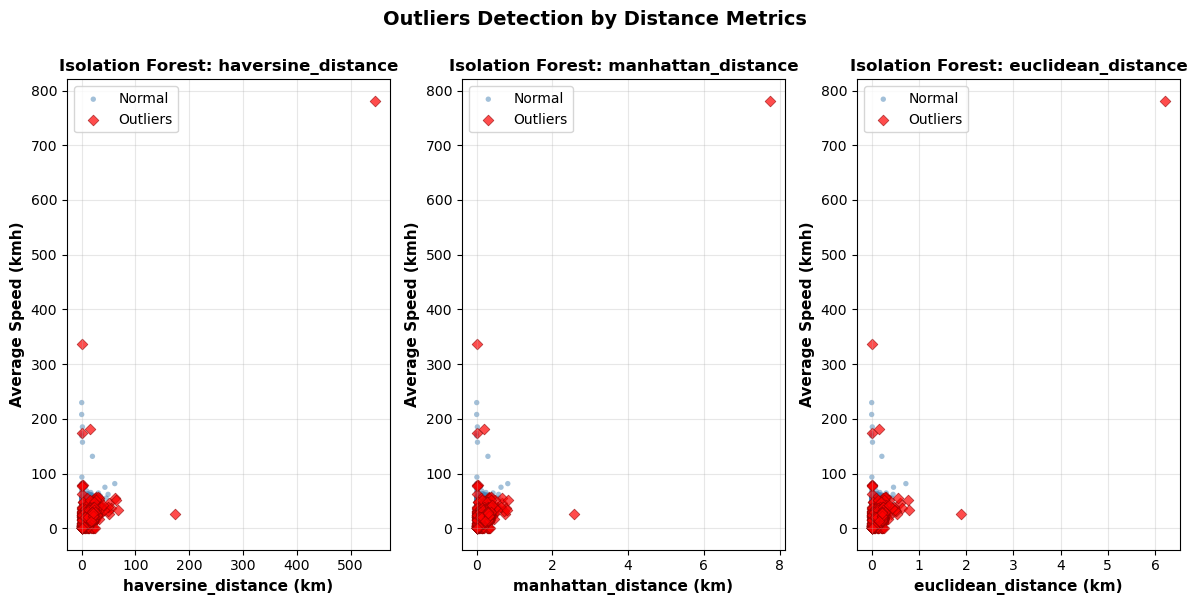

In [ ]:
# Scatter plots to visualize outliers in distance features
# Scatter plots show distance vs average speed to visualize detected outliers
# Note: Overlaps may appear because Isolation Forest identifies subtle outliers that may still lie close to normal points
distance_cols = ['haversine_distance', 'manhattan_distance', 'euclidean_distance']

# Create 3 plots horizontally
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for idx, col in enumerate(distance_cols):
    ax = axes[idx]
    
    # Normal points
    ax.scatter(
        df_outlier.loc[~df_outlier['is_outlier'], col],
        df_outlier.loc[~df_outlier['is_outlier'], 'avg_speed_kmh'],
        label='Normal',
        s=15,
        alpha=0.5,
        color='steelblue',
        edgecolors='none'
    )
    
    # Outlier points
    ax.scatter(
        df_outlier.loc[df_outlier['is_outlier'], col],
        df_outlier.loc[df_outlier['is_outlier'], 'avg_speed_kmh'],
        label='Outliers',
        s=30,
        color='red',
        alpha=0.7,
        marker='D',
        edgecolors='darkred',
        linewidth=0.5
    )
    
    ax.set_xlabel(f'{col} (km)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Average Speed (km/h)', fontsize=11, fontweight='bold')
    ax.set_title(f'Isolation Forest: {col}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('Outliers Detection by Distance Metrics', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

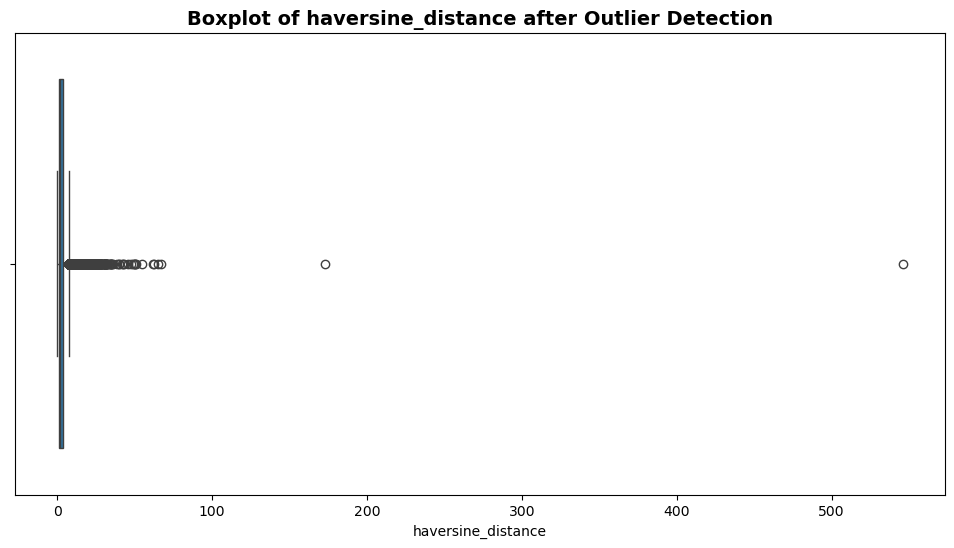

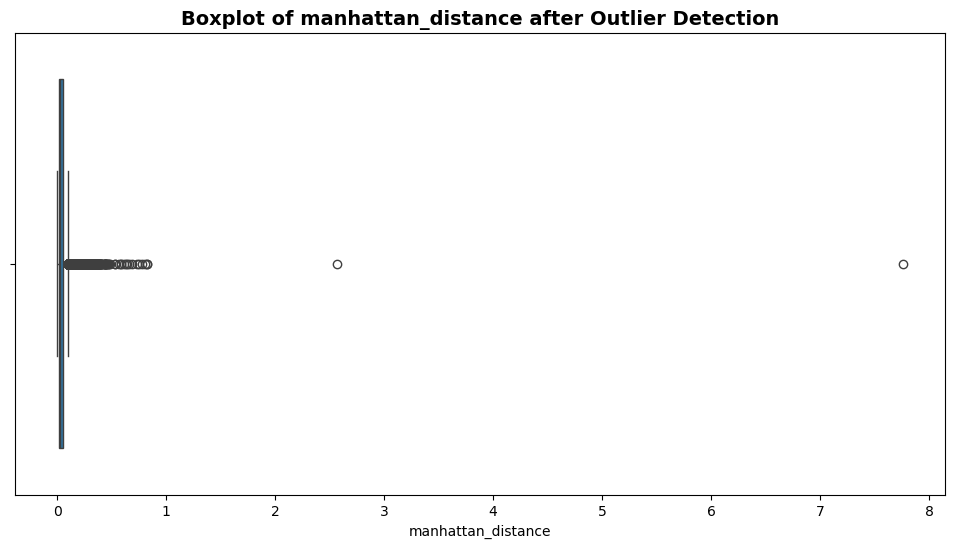

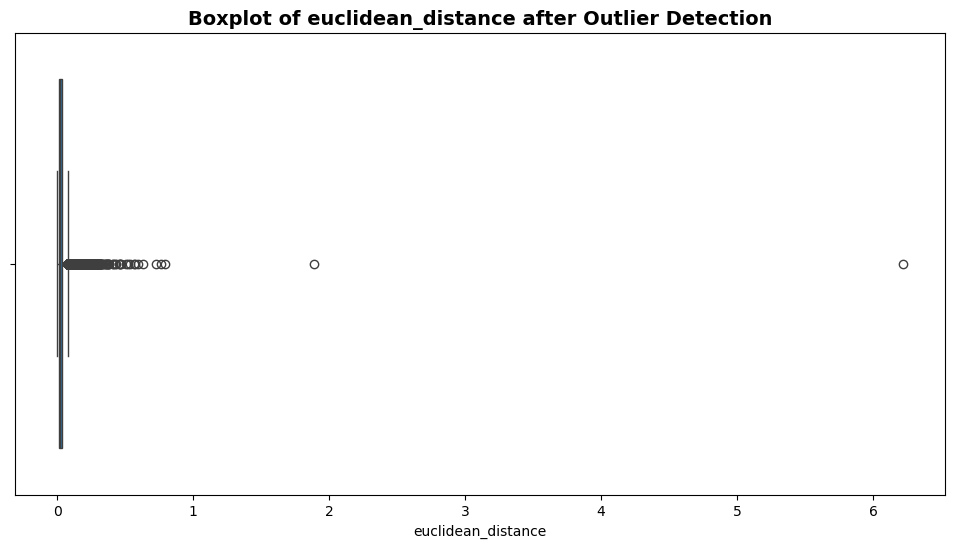

In [12]:
# Boxplots to visualize outliers in distance features
distance_cols = ['haversine_distance', 'manhattan_distance', 'euclidean_distance']
for col in distance_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_outlier[col])
    plt.title(f'Boxplot of {col} after Outlier Detection', fontsize=14, fontweight='bold')

plt.show()

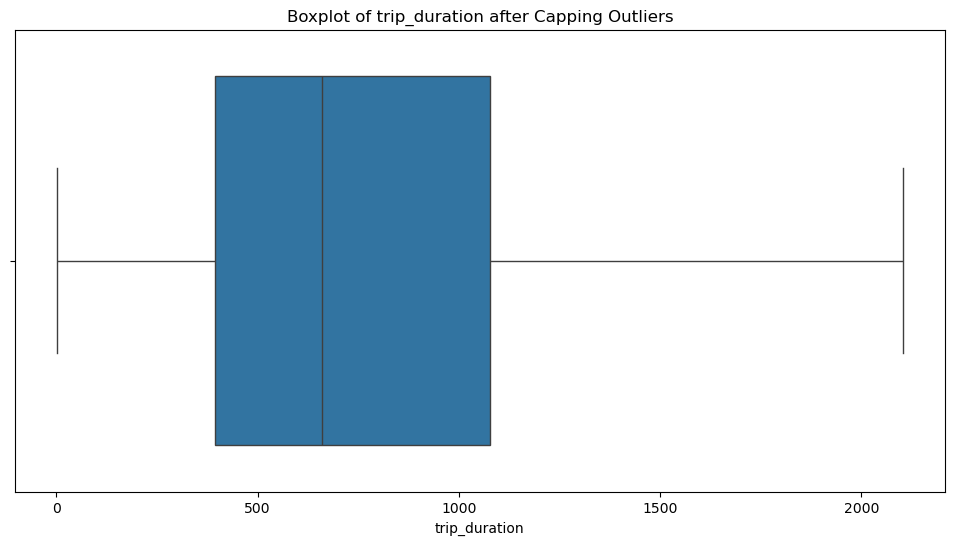

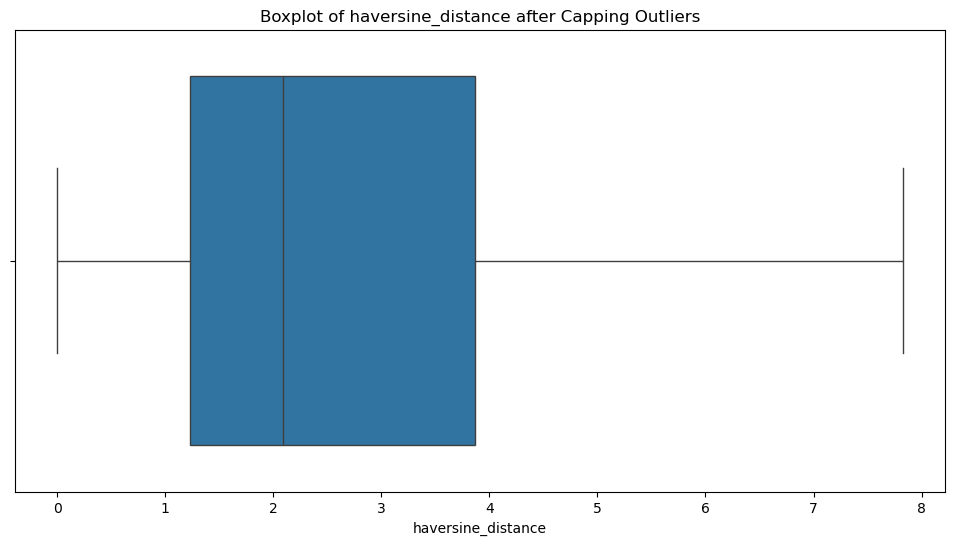

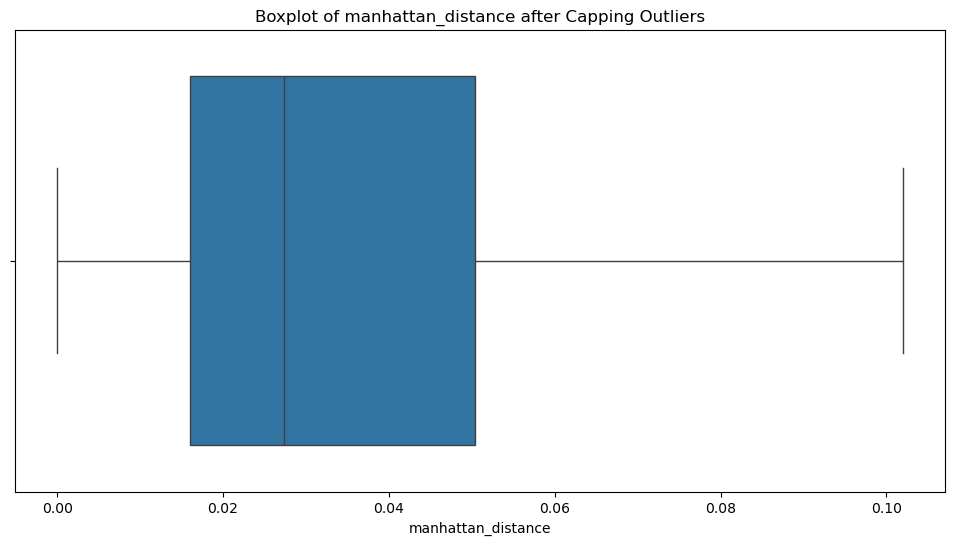

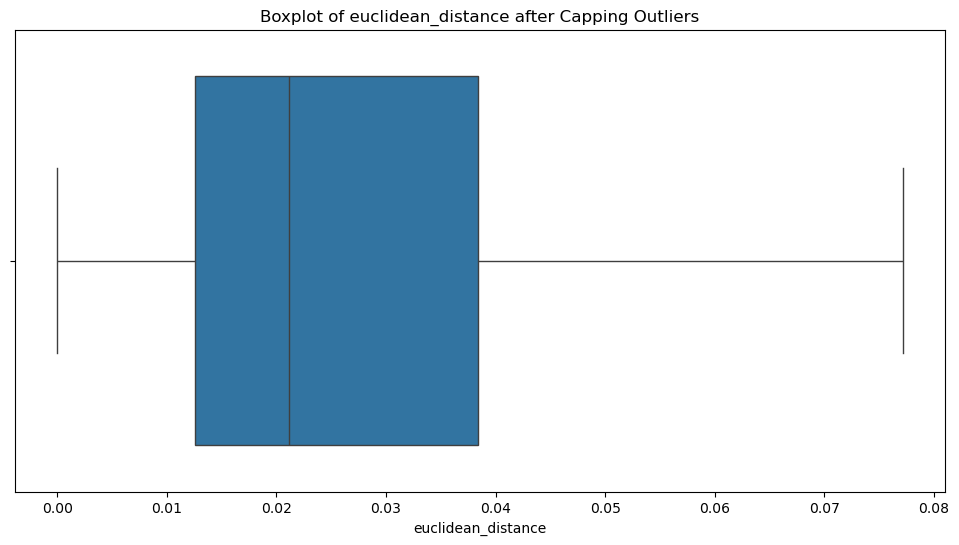

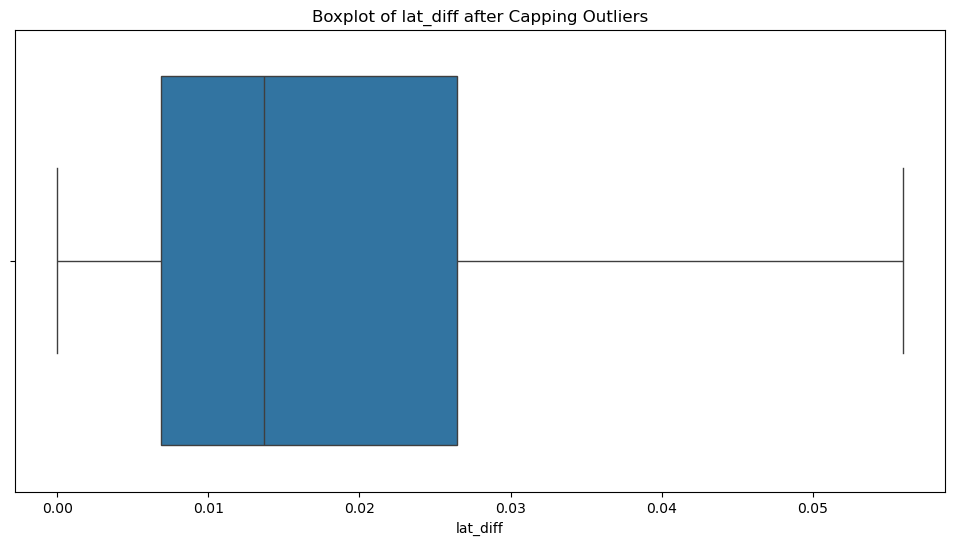

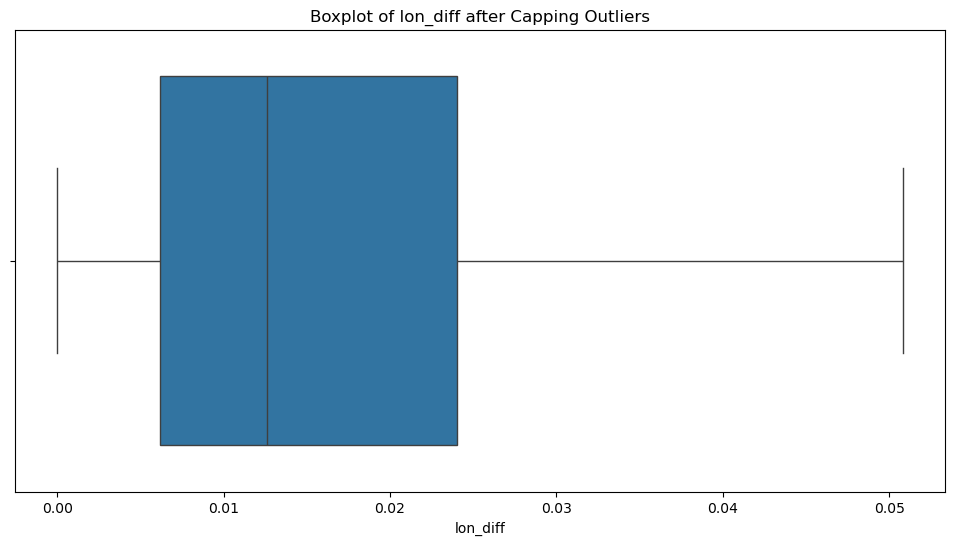

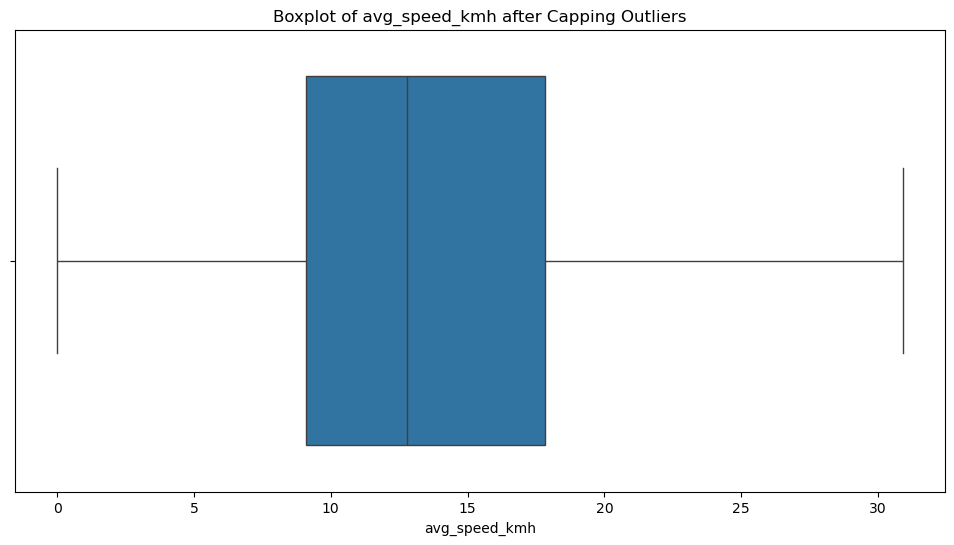

In [ ]:
# Handling outliers with Capping method
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    Lower_bound = Q1 - 1.5 * IQR
    Upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower = Lower_bound, upper = Upper_bound)

cap_columns = [
    'trip_duration',
    'haversine_distance',
    'manhattan_distance',
    'euclidean_distance',
    'lat_diff',
    'lon_diff',
    'avg_speed_kmh'
]

for col in cap_columns:
    df_outlier[col] = cap_outliers(df_outlier[col])
    df_model[col] = cap_outliers(df_model[col])

# Recompute log_trip_duration after capping to keep the target consistent in both DF's 
df_outlier['log_trip_duration'] = np.log1p(df_outlier['trip_duration'])
df_model['log_trip_duration'] = np.log1p(df_model['trip_duration'])

# Verify no outliers remain
# Boxplots after capping outliers
# Boxplots are created using df_outlier to highlight and explore outliers for analysis purposes
for col in cap_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_outlier[col])
    plt.title(f'Boxplot of {col} after Capping Outliers')
    plt.show()

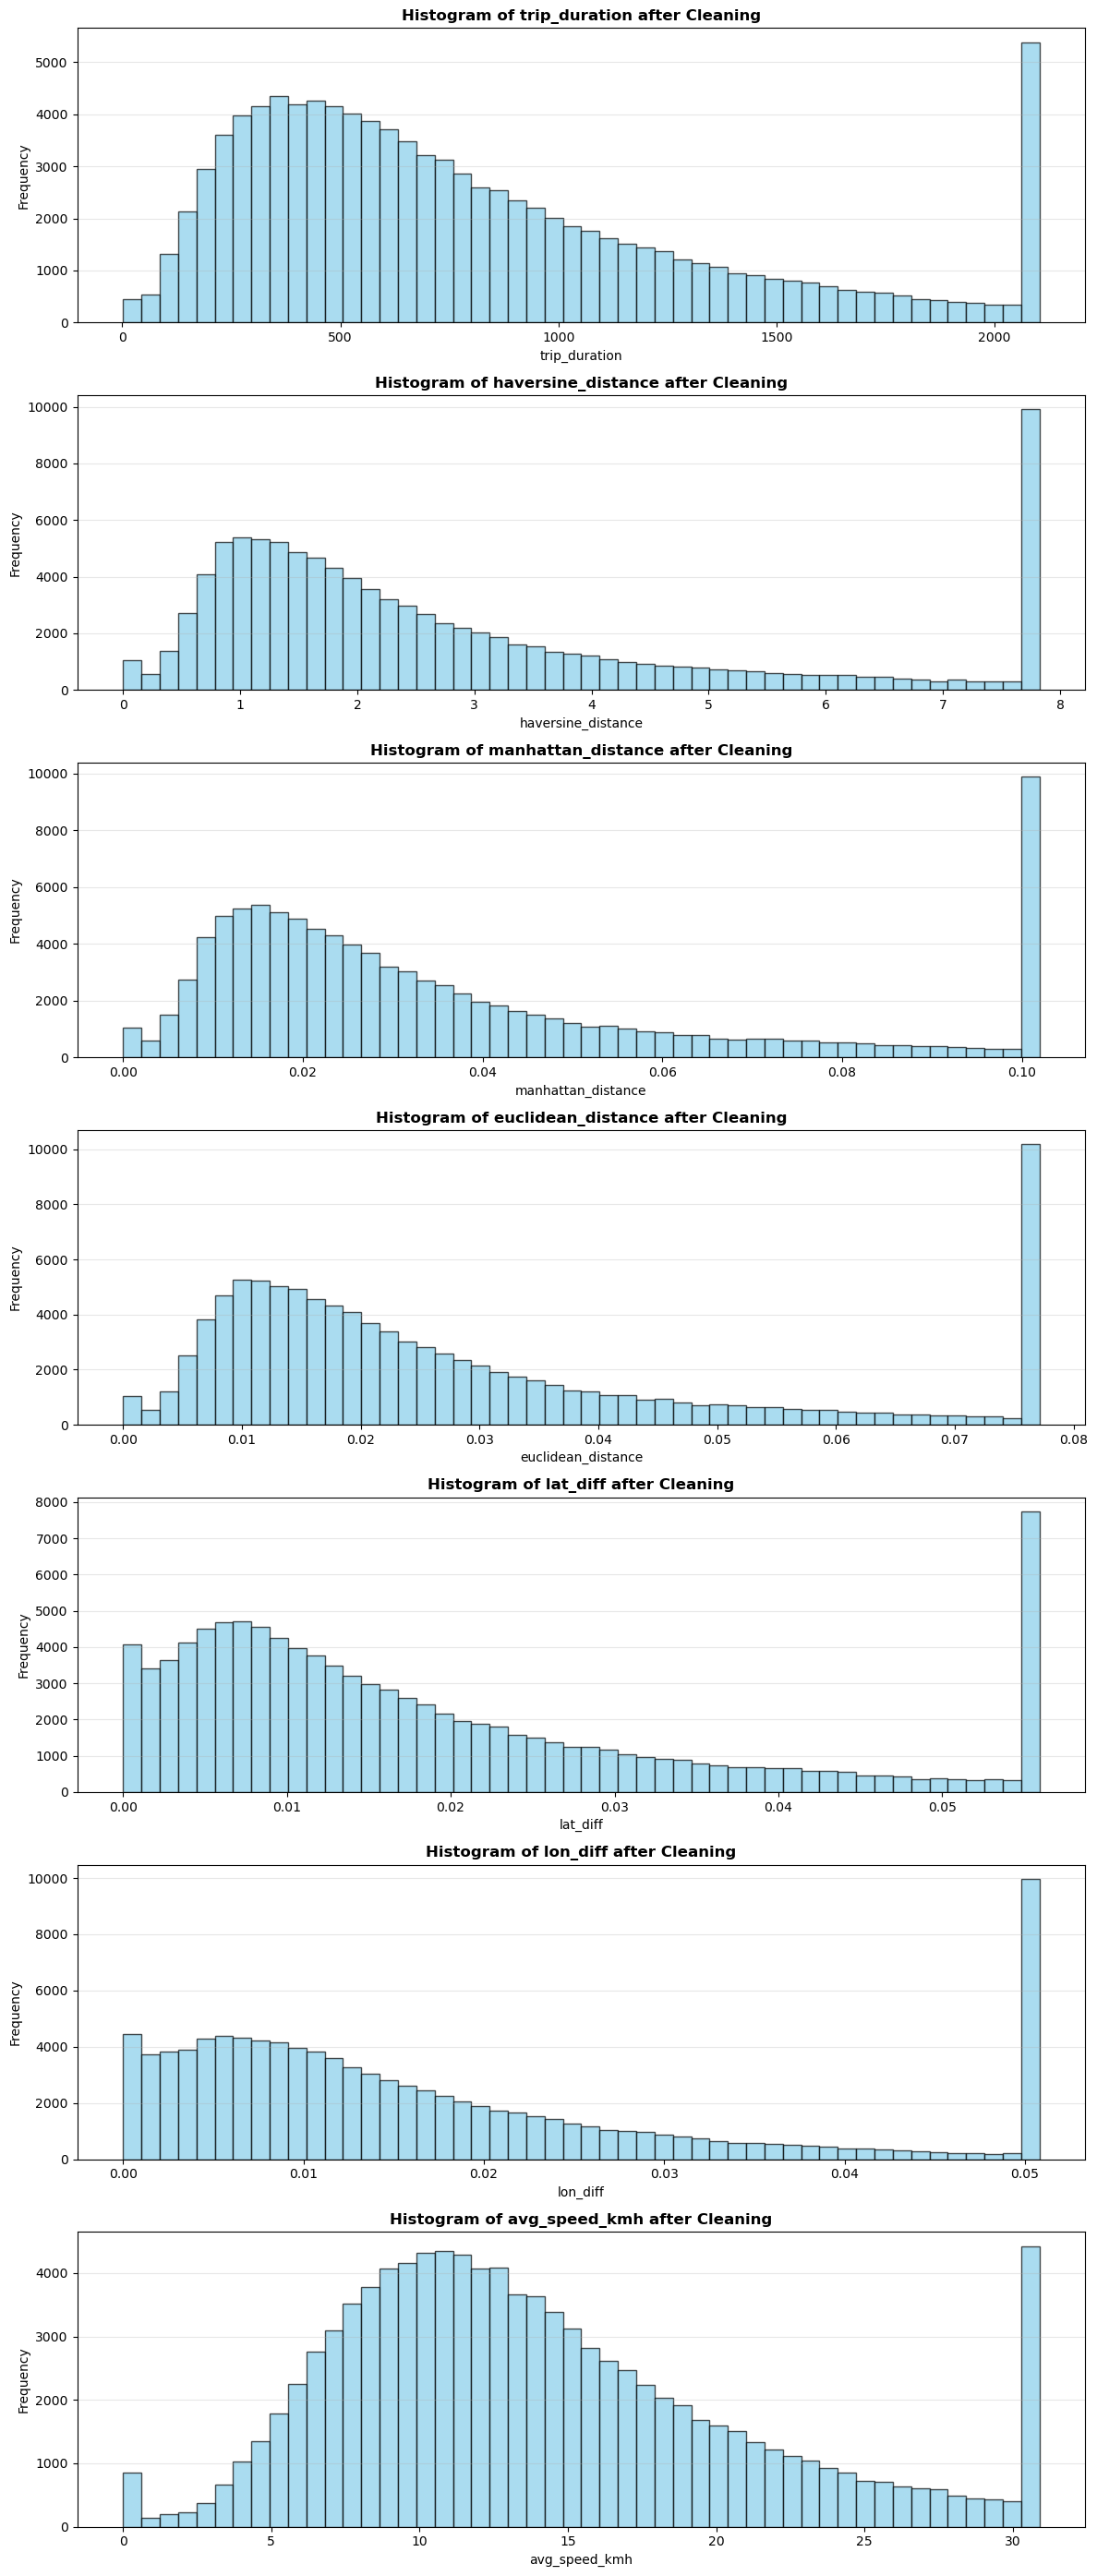

In [ ]:
# Make histograms of numerical features after cleaning
# Histograms are created using df_model to show the distribution of the features after outlier capping, representing what the model actually sees during training
cap_columns = [
    'trip_duration',
    'haversine_distance',
    'manhattan_distance',
    'euclidean_distance',
    'lat_diff',
    'lon_diff',
    'avg_speed_kmh'
]

fig, axes = plt.subplots(len(cap_columns), 1, figsize=(12, 4 * len(cap_columns)))

for idx, col in enumerate(cap_columns):
    axes[idx].hist(df_model[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Histogram of {col} (df_model after Capping)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Drop only truly unnecessary columns (keep datetime and location columns for feature engineering)
drop_cols = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    'store_and_fwd_flag',
    'avg_speed_kmh',
    'trip_duration'
    ]

df_model = df_model.drop(columns = drop_cols)
df_model.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,hour,day_of_week,month,haversine_distance,manhattan_distance,euclidean_distance,lat_diff,lon_diff
67250,2,1,-73.985611,40.735943,-73.980331,40.760468,6.947937,7,2,6,2.763050,0.029804,0.025087,0.024525,0.005280
1397036,2,1,-73.978394,40.764351,-73.991623,40.749859,6.719013,12,6,4,1.959178,0.027721,0.019622,0.014492,0.013229
1021087,2,5,-73.989059,40.744389,-73.973381,40.748692,6.421622,2,6,6,1.404772,0.019981,0.016258,0.004303,0.015678
951424,2,2,-73.990326,40.731136,-73.991264,40.748917,6.766192,17,3,5,1.978660,0.018719,0.017805,0.017780,0.000938
707882,1,4,-73.789497,40.646675,-73.987137,40.759232,7.651358,17,3,5,7.823950,0.101954,0.077125,0.055935,0.050800


In [25]:
# Make label encoder for categorical features with LightGBM method
categorical_cols = df_model.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    # Make instantiate of LabelEncoder
    label_encoder = LabelEncoder()

    # Apply Label Encoding
    df_model[col] = label_encoder.fit_transform(df_model[col].astype(str))

# Save the encoded dataframe to CSV
df_model.to_csv('data_encoded.csv', index=False)
print(f"Encoded data saved to 'data_encoded.csv'")
df_model.head()

Encoded data saved to 'data_encoded.csv'


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,hour,day_of_week,month,haversine_distance,manhattan_distance,euclidean_distance,lat_diff,lon_diff
67250,2,1,-73.985611,40.735943,-73.980331,40.760468,6.947937,7,2,6,2.763050,0.029804,0.025087,0.024525,0.005280
1397036,2,1,-73.978394,40.764351,-73.991623,40.749859,6.719013,12,6,4,1.959178,0.027721,0.019622,0.014492,0.013229
1021087,2,5,-73.989059,40.744389,-73.973381,40.748692,6.421622,2,6,6,1.404772,0.019981,0.016258,0.004303,0.015678
951424,2,2,-73.990326,40.731136,-73.991264,40.748917,6.766192,17,3,5,1.978660,0.018719,0.017805,0.017780,0.000938
707882,1,4,-73.789497,40.646675,-73.987137,40.759232,7.651358,17,3,5,7.823950,0.101954,0.077125,0.055935,0.050800


In [26]:
# Prepare features for LightGBM (exclude non-predictive columns)
feature_cols = [col for col in df_model.columns if col not in 
                ['pickup_datetime', 'trip_duration', 'log_trip_duration']]

X = df_model[feature_cols]
y = df_model['log_trip_duration']
    
# Train LightGBM model with safe tuning
model = LGBMRegressor(
    n_estimators=200,           # Increased from 100
    learning_rate=0.05,         # Reduced from 0.1 for better convergence
    num_leaves=31,              # Control tree complexity
    max_depth=7,                # Limit depth to prevent overfitting
    min_data_in_leaf=20,        # Minimum samples per leaf
    lambda_l1=0.5,              # L1 regularization
    lambda_l2=0.5,              # L2 regularization
    feature_fraction=0.8,       # Use 80% of features per tree
    bagging_fraction=0.8,       # Use 80% of data per iteration
    bagging_freq=5,             # Bagging frequency
    random_state=42,
    verbose=-1
)
model.fit(X, y)

# Display feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Make predictions
y_pred = model.predict(X)
print(f"\nModel R² Score: {model.score(X, y):.4f}")

Feature Importance:
               feature  importance
6                 hour         981
5     dropoff_latitude         803
4    dropoff_longitude         605
2     pickup_longitude         591
7          day_of_week         547
3      pickup_latitude         524
13            lon_diff         465
11  euclidean_distance         460
9   haversine_distance         328
12            lat_diff         312
10  manhattan_distance         157
8                month         113
0            vendor_id          72
1      passenger_count          42

Model R² Score: 0.7738


In [27]:
# Validate model with train-test-split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
val_score = model.score(x_val, y_val)
print(f"Validation R² Score: {val_score:.4f}")

Validation R² Score: 0.7519


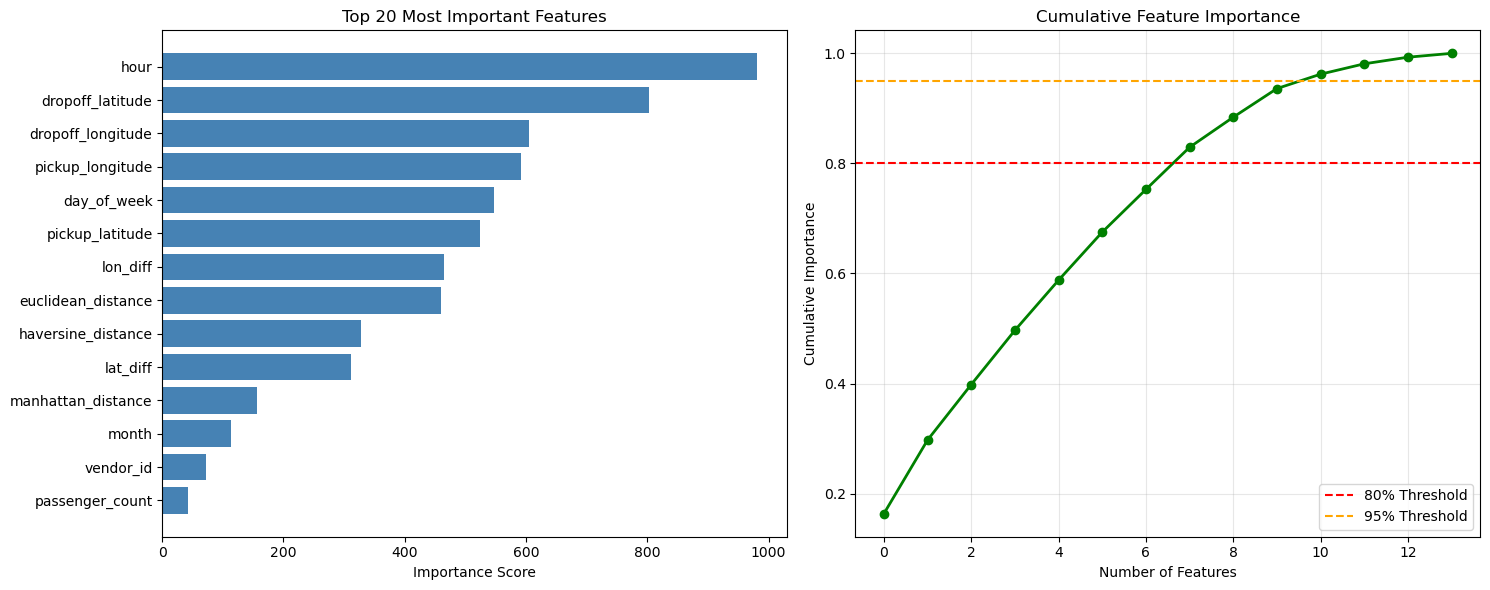


Top 10 Most Important Features:
           feature  importance
              hour         981
  dropoff_latitude         803
 dropoff_longitude         605
  pickup_longitude         591
       day_of_week         547
   pickup_latitude         524
          lon_diff         465
euclidean_distance         460
haversine_distance         328
          lat_diff         312

Total Features: 14
Features needed for 80% importance: 8
Features needed for 95% importance: 11


In [28]:
# Visualize Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot - Top 20 features
top_features = feature_importance.head(20)
axes[0].barh(top_features['feature'], top_features['importance'], color='steelblue')
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Top 20 Most Important Features')
axes[0].invert_yaxis()

# Cumulative importance
cumulative_importance = np.cumsum(feature_importance['importance'].values)
cumulative_importance = cumulative_importance / cumulative_importance[-1]
axes[1].plot(cumulative_importance, 'o-', color='green', linewidth=2)
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% Threshold')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% Threshold')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Feature Importance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))
print(f"\nTotal Features: {len(feature_importance)}")
print(f"Features needed for 80% importance: {np.argmax(cumulative_importance >= 0.8) + 1}")
print(f"Features needed for 95% importance: {np.argmax(cumulative_importance >= 0.95) + 1}")

In [ ]:
# Cross-validation and Hyperparameter Optimization
# 1. Cross-validation with current model
print("=" * 60)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("=" * 60)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 2. Grid Search for hyperparameter optimization
# For faster hyperparameter tuning, GridSearchCV is run on a smaller random sample of the dataset
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING (GridSearchCV)")
print("=" * 60)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [5, 7, 10],
    'lambda_l1': [0.1, 0.5, 1.0],
    'lambda_l2': [0.1, 0.5, 1.0]
}

# Using smaller sample for faster grid search
lgbm_base = LGBMRegressor(
    n_estimators=100,
    random_state=42,
    verbose=-1
)

grid_search = GridSearchCV(
    lgbm_base,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
# The final LightGBM model is trained on the full dataset using the best parameters from GridsearchCV
# This ensures the model learns from all available data
best_model = LGBMRegressor(
    n_estimators=200,
    **grid_search.best_params_,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    verbose=-1
)

best_model.fit(x_train, y_train)
best_val_score = best_model.score(x_val, y_val)

print(f"\n" + "=" * 60)
print("OPTIMIZED MODEL PERFORMANCE")
print("=" * 60)
print(f"Validation R² Score (Optimized): {best_val_score:.4f}")
print(f"Previous R² Score: {val_score:.4f}")
print(f"Improvement: {best_val_score - val_score:+.4f}")

# Additional metrics
y_pred_best = best_model.predict(x_val)
mae = mean_absolute_error(y_val, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_best))

print(f"\nValidation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

CROSS-VALIDATION RESULTS (5-Fold)
CV Scores: [0.75588754 0.75671015 0.75124946 0.74260033 0.757536  ]
Mean CV R² Score: 0.7528 (+/- 0.0055)

HYPERPARAMETER TUNING (GridSearchCV)
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best Parameters: {'lambda_l1': 1.0, 'lambda_l2': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 63}
Best CV R² Score: 0.7624

OPTIMIZED MODEL PERFORMANCE
Validation R² Score (Optimized): 0.7647
Previous R² Score: 0.7519
Improvement: +0.0128

Validation Metrics:
MAE: 0.2519
RMSE: 0.3618
